In [246]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [247]:
# 요약 함수 모음

## train, test 불러오기
def load_traintest_dt():
    train = pd.read_csv('../data/titanic/train.csv')
    test = pd.read_csv('../data/titanic/test.csv')  

    return (train, test)

## submission_a 불러오기
def load_submission_a() :
    submission_a = pd.read_csv('../data/submission_a.csv')
    del submission_a['PassengerId']

    return submission_a

## 피처 삭제
def drop_col(train,test,col_list):
    '''
    drop train, test column
    parameter : train,test, list
    return train,test
    '''
    train = train.drop(col_list,axis=1)
    test = test.drop(col_list, axis=1)
    return (train,test)

## train, target 나누기
def split_data(train):
    train_data = train.drop('Survived',axis=1)
    target = train['Survived']

    return (train_data, target)

## cleaning

In [248]:
# 데이터 전처리 함수

    # Name,Title
def Name_cleaning(train,test):
    
    train_test_data = [train,test]
    for dataset in train_test_data:
        dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)

    train_title_mapping = {'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3
                    , 'Dr':4, 'Rev':4, 'Mlle':4, 'Major':4, 'Col':4
                    ,'Countess':4, 'Capt':4, 'Ms':4, 'Sir':4, 'Lady':4
                    , 'Mme':4, 'Don':4, 'Jonkheer':4
                    }
    train['Title'] = train['Title'].map(train_title_mapping)

    test_title_mapping = {'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3
                    , 'Col':4, 'Rev':4, 'Ms':4, 'Dr':4, 'Dona':4
                    }

    test['Title'] = test['Title'].map(test_title_mapping)

    return (train,test)

    # sex
def sex_cleaning(train,test):
    sex_mapping = {'male':0, 'female':1}
    train_test_data = [train,test]
    for dataset in train_test_data:
        dataset['Sex'] = dataset['Sex'].map(sex_mapping)

    return (train,test)

    # Have Age
def haveage_cleaning(train,test):

    train.loc[train['Age'].isnull(), 'Null_Age'] = 0
    test.loc[test['Age'].isnull(), 'Null_Age'] = 0

    train.loc[train['Age'].notnull(), 'Null_Age'] = 1
    test.loc[test['Age'].notnull(), 'Null_Age'] = 1

    return (train,test)


    # Age
def age_cleaning(train,test):
    
    train['Age'].fillna(train.groupby('Title')['Age'].transform('mean'),inplace=True)
    test['Age'].fillna(test.groupby('Title')['Age'].transform('mean'),inplace=True)

    train_test_data = [train,test]
    for dataset in train_test_data:
        dataset.loc[dataset['Age'] <= 17, 'Age'] =0
        dataset.loc[(dataset['Age'] >17) & (dataset['Age'] <= 24), 'Age'] = 1
        dataset.loc[(dataset['Age'] >24) & (dataset['Age'] <= 34), 'Age'] = 2
        dataset.loc[(dataset['Age'] >34) & (dataset['Age'] <= 44), 'Age'] = 3
        dataset.loc[(dataset['Age'] >44) & (dataset['Age'] <= 60), 'Age'] = 4
        dataset.loc[dataset['Age'] >60, 'Age'] = 5

    return (train,test)


    # Embarked
def embarked_cleaning(train,test):

    train['Embarked'] = train['Embarked'].fillna('S')
    test['Embarked'] = test['Embarked'].fillna('S')

    embarked_mapping = {'S':0, 'C':1, 'Q':2}
    train['Embarked'] = train['Embarked'].map(embarked_mapping)
    test['Embarked'] = test['Embarked'].map(embarked_mapping)

    return (train,test)

    #Fare
def fare_cleaning(train,test):

    test['Fare'].fillna(
        test.groupby('Pclass')['Fare'].transform('median'), inplace=True
    )
    
    train.loc[train['Fare'] == 0, 'Zero_Fare'] = 0
    test.loc[test['Fare'] == 0, 'Zero_Fare'] = 0

    train.loc[train['Fare'] != 0, 'Zero_Fare'] = 1
    test.loc[test['Fare'] != 0, 'Zero_Fare'] = 1


    return (train,test)

    # group_size
def groupsize_cleanig(train,test):

    for ticket_num in train['Ticket'].unique():
        train.loc[train['Ticket']==ticket_num,'group_size'] = len(train[train['Ticket']==ticket_num])

    for ticket_num in test['Ticket'].unique():
        test.loc[test['Ticket']==ticket_num,'group_size'] = len(test[test['Ticket']==ticket_num])

    train['Fare'] = train['Fare']/train['group_size']
    test['Fare'] = test['Fare']/test['group_size']
    
    # train_test_data = [train,test]
    # for dataset in train_test_data:
    #     dataset.loc[dataset['group_size'] == 1, 'group_size'] = 0
    #     dataset.loc[dataset['group_size'] == 2, 'group_size'] = 0.4
    #     dataset.loc[(dataset['group_size'] == 3) | (dataset['group_size'] == 4), 'group_size'] = 0.8
    #     dataset.loc[dataset['group_size'] > 4, 'group_size'] = 1.2

    # train_test_data = [train,test]
    # for dataset in train_test_data:

    #     dataset.loc[dataset['Fare'] <= 7,'Fare'] = 0
    #     dataset.loc[(dataset['Fare'] >7) & (dataset['Fare'] <=8.8), 'Fare'] = 0.4
    #     dataset.loc[(dataset['Fare'] >8.8) & (dataset['Fare'] <=17), 'Fare'] = 0.8
    #     dataset.loc[(dataset['Fare'] >17) & (dataset['Fare'] <=30), 'Fare'] = 1.2
    #     dataset.loc[(dataset['Fare'] >30) & (dataset['Fare'] <=100), 'Fare'] = 1.6
    #     dataset.loc[dataset['Fare'] > 100,'Fare'] = 2
        
    return (train,test)

    # Have Cabin
def havecabin_cleaning(train,test):

    train.loc[train['Cabin'].isnull(), 'Null_Cabin'] = 0
    test.loc[test['Cabin'].isnull(), 'Null_Cabin'] = 0

    train.loc[train['Cabin'].notnull(), 'Null_Cabin'] = 1
    test.loc[test['Cabin'].notnull(), 'Null_Cabin'] = 1

    return (train,test)

    # Cabin
def cabin_cleaning(train,test):

    train['Cabin'] = train['Cabin'].str[:1]
    test['Cabin'] = test['Cabin'].str[:1]

    cabin_mapping = {"A": 0, "B": 0.4
                    , "C": 0.8, "D": 1.2
                    , "E": 1.6, "F": 2, "G": 2.4
                    , 'T' :2.8
                    }

    train['Cabin'] = train['Cabin'].map(cabin_mapping)
    test['Cabin'] = test['Cabin'].map(cabin_mapping)

    train["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
    test["Cabin"].fillna(test.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

    return (train,test)

    # FamilySize
def familysize_cleaning(train,test):

    train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
    test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

    # family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
    # train['FamilySize'] = train['FamilySize'].map(family_mapping)
    # test['FamilySize'] = test['FamilySize'].map(family_mapping)

    return (train,test)

    # 정규화
def data_scaler(train,test,columns):
 
    train_test_data = [train,test]
    for dataset in train_test_data:
        scaler = MinMaxScaler()
        # scaler = StandardScaler()

        scaler.fit(dataset[columns])
        scaled = scaler.transform(dataset[columns])

        df_scaled = pd.DataFrame(data=scaled, columns=columns)
        dataset.loc[:,columns] = df_scaled

    return (train,test)

In [249]:
def Family_Survival(data_df,train,test):


    data_df['Lastname'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])

    DEFAULT_SURVIVAL_VALUE = 0.5
    data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

    for grp, grp_df in data_df[['Survived','Name', 'Lastname', 'Fare', 'Ticket', 'PassengerId',
                            'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Lastname', 'Fare']):
        
        if (len(grp_df) != 1):
            # A Family group is found.
            for ind, row in grp_df.iterrows():
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

    for _, grp_df in data_df.groupby('Ticket'):
        if (len(grp_df) != 1):
            for ind, row in grp_df.iterrows():
                if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                    smax = grp_df.drop(ind)['Survived'].max()
                    smin = grp_df.drop(ind)['Survived'].min()
                    passID = row['PassengerId']
                    if (smax == 1.0):
                        data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                    elif (smin==0.0):
                        data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

    # # Family_Survival in TRAIN_DF and TEST_DF:
    train['Family_Survival'] = data_df['Family_Survival'][:891]
    test['Family_Survival'] = data_df['Family_Survival'][891:]

    return (train,test)

In [250]:
# 8373

def data_cleaning():
    train,test = load_traintest_dt()
    data_df = pd.concat([train,test])
    
    #name
    train,test = Name_cleaning(train,test)
    #sex
    train,test = sex_cleaning(train,test)
    #haveage
    train,test = haveage_cleaning(train,test)
    #age
    train,test = age_cleaning(train,test)
    #embarked
    train,test = embarked_cleaning(train,test)
    #fare
    train,test = fare_cleaning(train,test)
    #groupsize
    train,test = groupsize_cleanig(train,test)
    #havecabin
    train,test = havecabin_cleaning(train,test)
    #cabin
    train,test = cabin_cleaning(train,test)
    #familysize
    train,test = familysize_cleaning(train,test)
    
    #familysurvival
    data_df = Family_Survival(data_df,train,test)


    #drop
    train,test = drop_col(train,test,['Ticket','SibSp','Parch','Name'])

    # 컬럼 순서 조정
    train = train[['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin',
       'Embarked', 'Title', 'group_size',
       'FamilySize', 'Family_Survival']]
    test = test[['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked',
        'Title', 'group_size', 'FamilySize',
        'Family_Survival']]
    #scaler
    columns = ['Pclass', 'Sex','Age'
               , 'Fare', 'Cabin'
               , 'Embarked', 'Title'
                , 'group_size'
                ,'FamilySize','Family_Survival'
                ]
    train,test = data_scaler(train,test,columns)

    #split

    train_data, target = split_data(train)

    return (train_data, target,test)

In [251]:
train,test = load_traintest_dt()
data_df = pd.concat([train,test])
#name
train,test = Name_cleaning(train,test)
#sex
train,test = sex_cleaning(train,test)
#groupsize
train,test = groupsize_cleanig(train,test)
#haveage
train,test = haveage_cleaning(train,test)
# #age
# train,test = age_cleaning(train,test)
#embarked
train,test = embarked_cleaning(train,test)
#fare
train,test = fare_cleaning(train,test)
#havecabin
train,test = havecabin_cleaning(train,test)
#cabin
train,test = cabin_cleaning(train,test)
#familysize
train,test = familysize_cleaning(train,test)
#familysurvival
data_df = Family_Survival(data_df,train,test)

train = train[['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin',
       'Embarked', 'Title', 'group_size','FamilySize', 'Family_Survival']]
test = test[['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked',
       'Title', 'group_size', 'FamilySize','Family_Survival']]

In [252]:
train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,group_size,FamilySize,Family_Survival
0,1,0,3,0,22.0,7.2500,2.0,0,0,1.0,2,0.5
1,2,1,1,1,38.0,71.2833,0.8,1,2,1.0,2,0.5
2,3,1,3,1,26.0,7.9250,2.0,0,1,1.0,1,0.5


---

## Age predict

In [253]:
train['Age'].isnull().sum(), test['Age'].isnull().sum()

(177, 86)

In [254]:
train['Age'].notnull().sum(), test['Age'].notnull().sum()

(714, 332)

In [255]:
isnull_age = pd.concat([train[train['Age'].isnull()],test[test['Age'].isnull()]],ignore_index=True)
notnull_age = pd.concat([train[train['Age'].notnull()],test[test['Age'].notnull()]],ignore_index=True)

notnull_age = notnull_age[['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin','Embarked', 'Title', 'group_size','FamilySize', 'Family_Survival']]
isnull_age = isnull_age[['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin','Embarked', 'Title', 'group_size','FamilySize', 'Family_Survival']]

In [256]:
notnull_age['Age'].unique()

array([22.  , 38.  , 26.  , 35.  , 54.  ,  2.  , 27.  , 14.  ,  4.  ,
       58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,  8.  ,
       19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  , 49.  ,
       29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  , 16.  ,
       25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  , 71.  ,
       37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 , 51.  ,
       55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  , 45.5 ,
       20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  , 60.  ,
       10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  , 70.  ,
       24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  , 22.5 , 18.5 ,
       67.  , 76.  , 26.5 , 60.5 , 11.5 ,  0.33,  0.17, 38.5 ])

In [257]:
notnull_age_ohe1 = pd.get_dummies(notnull_age ,columns=['Pclass', 'Sex', 'Embarked', 'Family_Survival'])

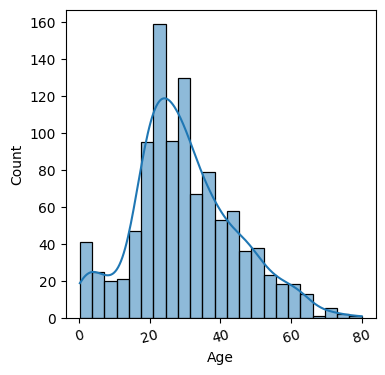

In [258]:
# Age(원래 답) 히스토그램

plt.figure(figsize=(4,4))
plt.xticks(rotation=15)
sns.histplot(notnull_age['Age'], kde=True)
plt.show()

In [259]:
# 로그 변환
original_Age = notnull_age['Age']
notnull_age['Age'] = np.log1p(notnull_age['Age'])

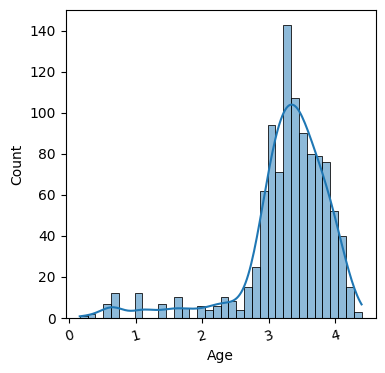

In [260]:
# 로그변환 후 히스토그램

plt.figure(figsize=(4,4))
plt.xticks(rotation=15)
sns.histplot(notnull_age['Age'], kde=True)
plt.show()

In [261]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [262]:
y_target = notnull_age['Age']
X_features = notnull_age_ohe1.drop(['Age'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0)

In [263]:
# model = fit된 것

def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [264]:
# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)


ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)


lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)


models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.556
Ridge 로그 변환된 RMSE: 0.556
Lasso 로그 변환된 RMSE: 0.603


[0.5560648549161882, 0.5557585417026489, 0.6032003712123077]

In [265]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)
   
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

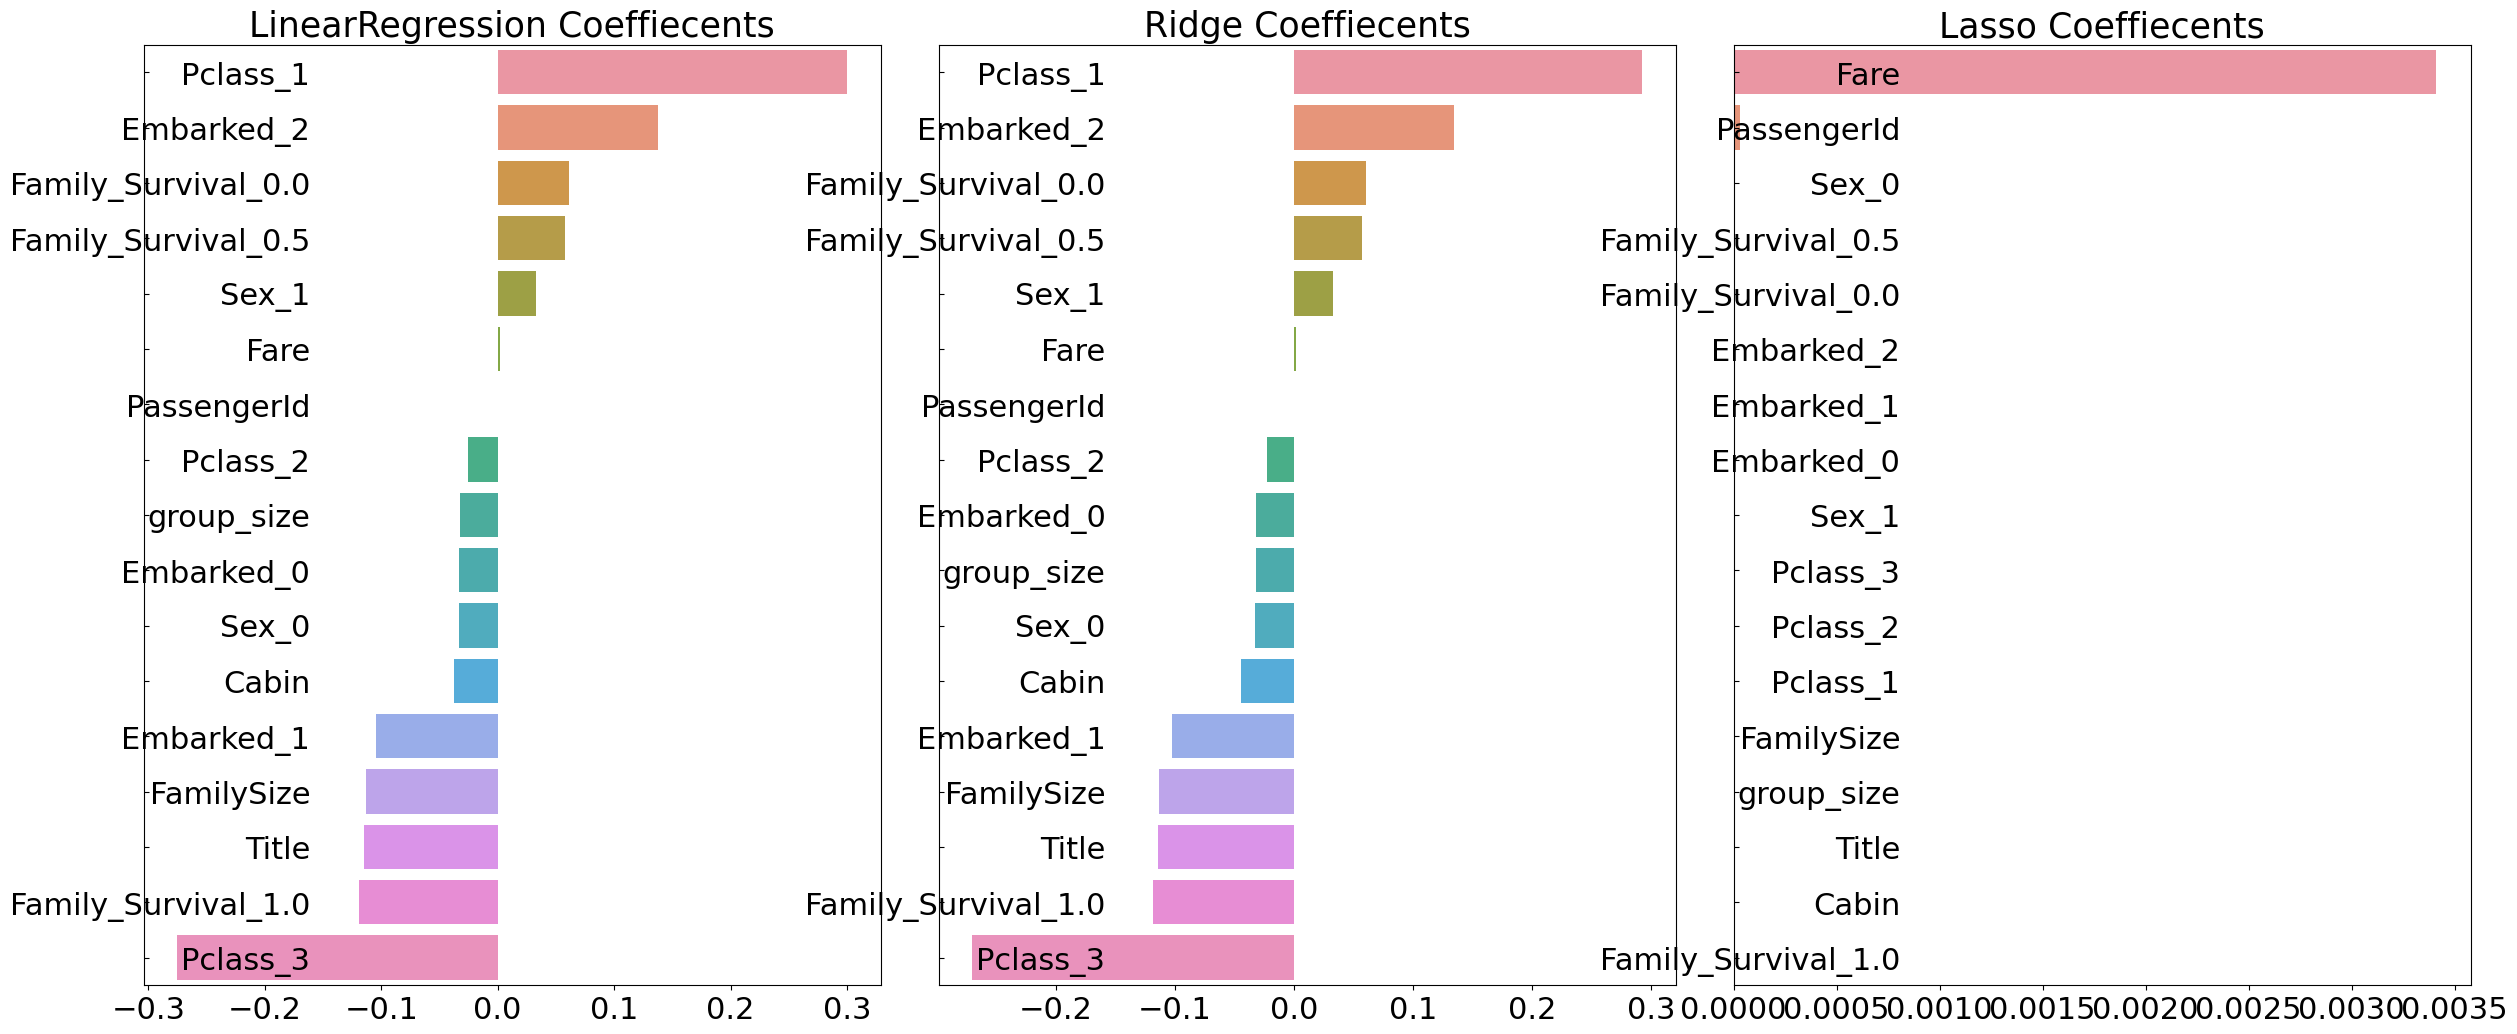

In [266]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합.
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])


# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [267]:
from sklearn.model_selection import cross_val_score


def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))


# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력          
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.58  0.573 0.582 0.561 0.623]
LinearRegression CV 평균 RMSE 값: 0.584

Ridge CV RMSE 값 리스트: [0.58  0.573 0.582 0.561 0.623]
Ridge CV 평균 RMSE 값: 0.584

Lasso CV RMSE 값 리스트: [0.698 0.669 0.608 0.639 0.697]
Lasso CV 평균 RMSE 값: 0.662


In [268]:
from sklearn.model_selection import GridSearchCV


def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_


ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.584, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.5842, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.556
Ridge 로그 변환된 RMSE: 0.553
Lasso 로그 변환된 RMSE: 0.555


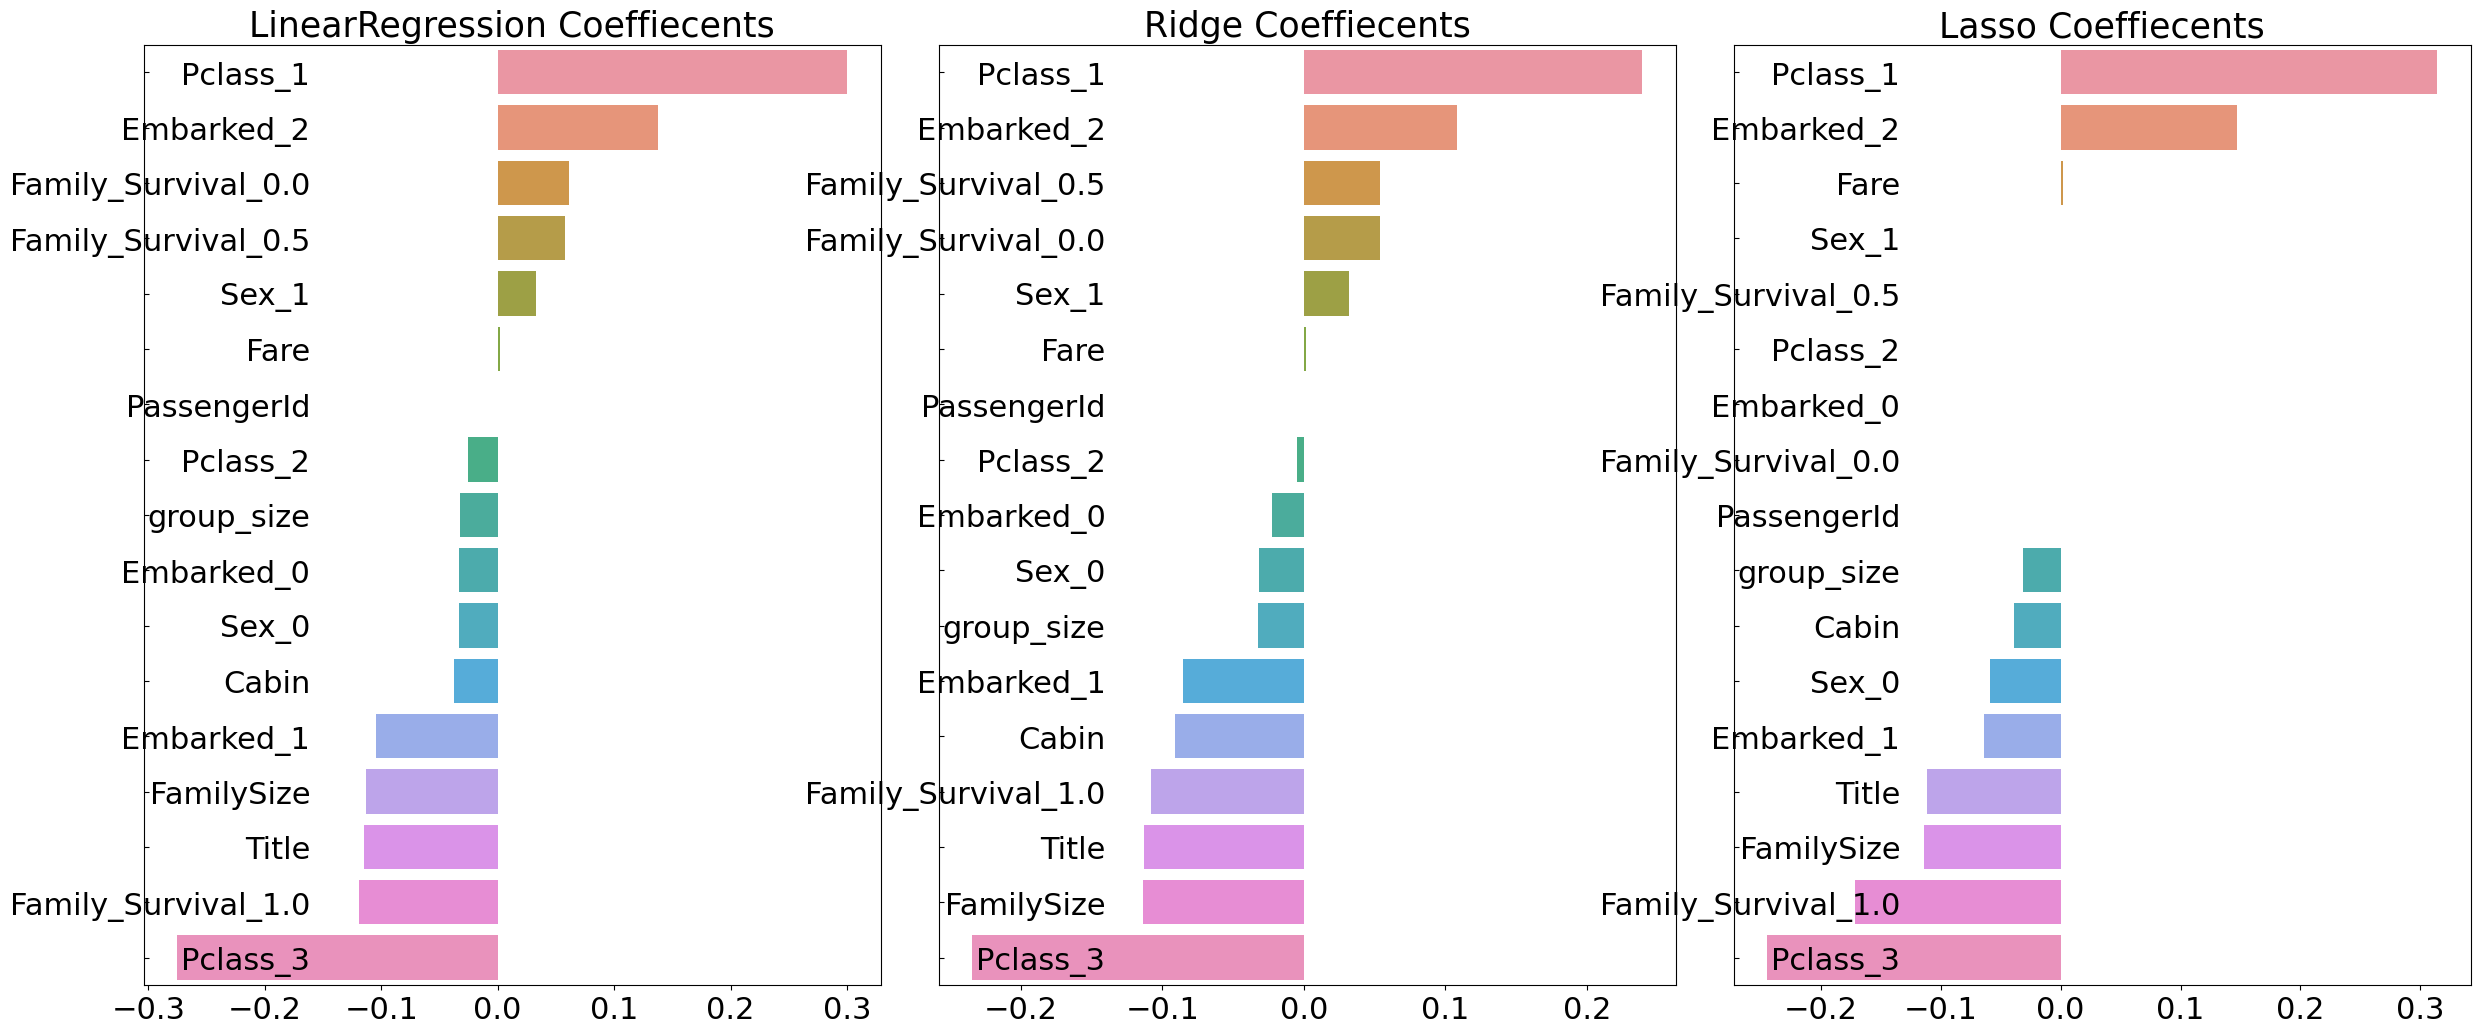

In [269]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)


# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [270]:
from scipy.stats import skew

In [271]:
# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = notnull_age_ohe1.dtypes[notnull_age_ohe1.dtypes != 'object'].index
# notnull_age에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = notnull_age_ohe1[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

Fare                   7.008853
Embarked_2             4.239127
group_size             2.305794
FamilySize             2.150421
Family_Survival_0.0    1.570480
Embarked_1             1.479243
Title                  1.238441
Pclass_2               1.157647
Family_Survival_1.0    1.099753
Pclass_1               1.027522
dtype: float64


In [272]:
notnull_age_ohe1[skew_features_top.index] = np.log1p(notnull_age_ohe1[skew_features_top.index])

In [273]:
notnull_age_ohe1.columns

Index(['PassengerId', 'Age', 'Fare', 'Cabin', 'Title', 'group_size',
       'FamilySize', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_0', 'Sex_1',
       'Embarked_0', 'Embarked_1', 'Embarked_2', 'Family_Survival_0.0',
       'Family_Survival_0.5', 'Family_Survival_1.0'],
      dtype='object')

In [274]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
notnull_age_ohe2 = pd.get_dummies(notnull_age_ohe1 ,columns=['Title', 'group_size', 'FamilySize'])
y_target = notnull_age['Age']
X_features = notnull_age_ohe2.drop('Age',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0)


# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값: 0.4535, 최적 alpha:{'alpha': 1}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.4518, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.457
Ridge 로그 변환된 RMSE: 0.457
Lasso 로그 변환된 RMSE: 0.456


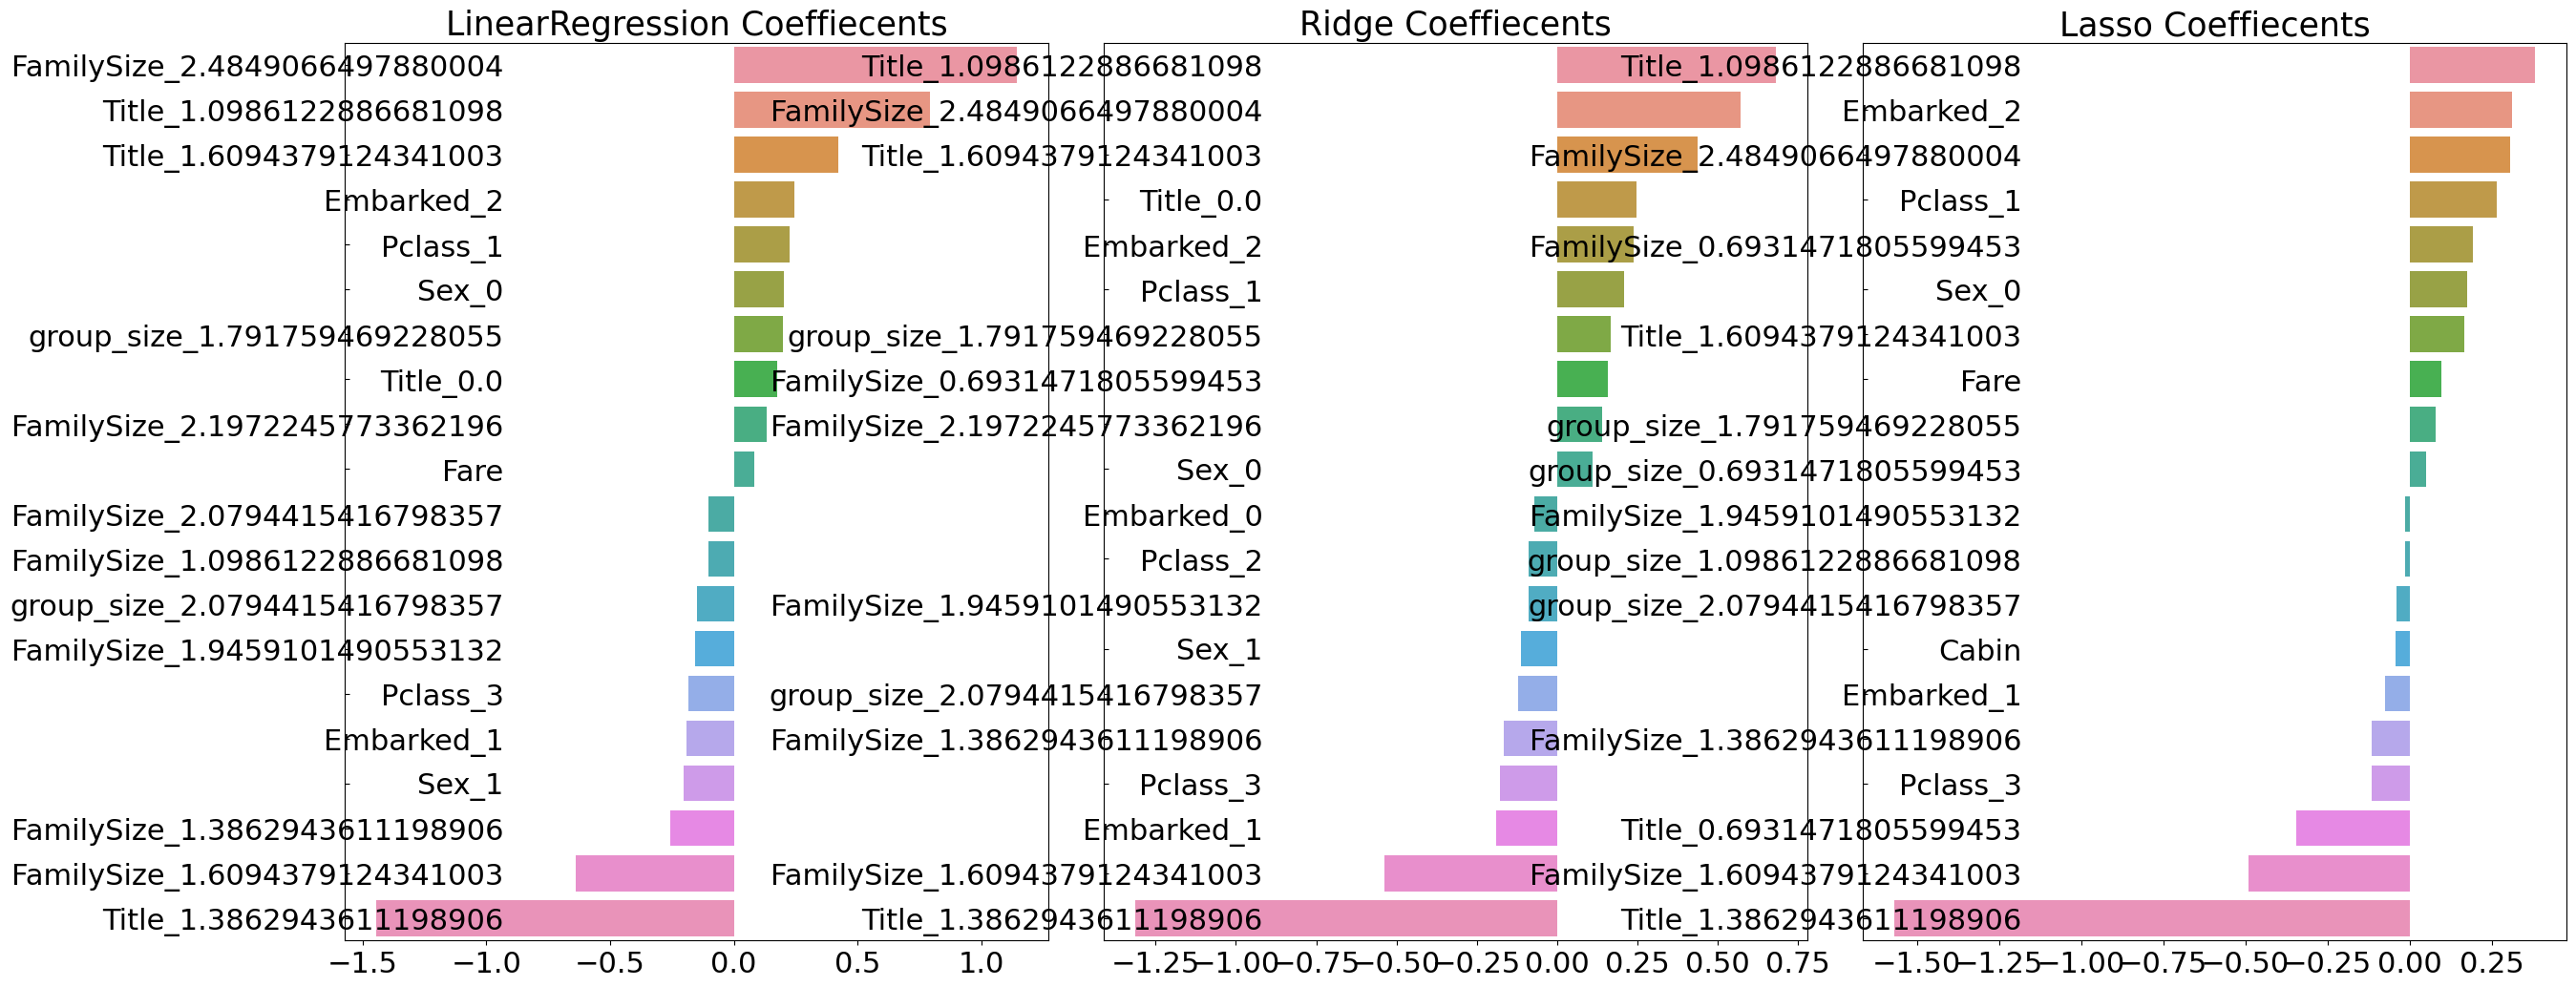

In [275]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)


# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models) # test data 오차


# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

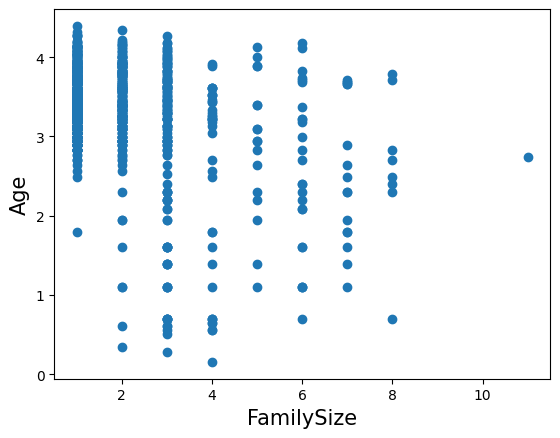

In [276]:
# 이상치 데이터 처리
# 회귀계수가 높은 피처, 즉 예측에 영향을 미치는 중요 피처의 이상치 데이터의 처리가 중요

plt.scatter(x = notnull_age['FamilySize'], y = notnull_age['Age'])
plt.ylabel('Age', fontsize=15)
plt.xlabel('FamilySize', fontsize=15)
plt.show()


In [277]:
# # GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성.
# cond1 = notnull_age_ohe1['FamilySize'] > np.log1p(7)
# cond2 = notnull_age_ohe1['Age'] < np.log1p(2)
# outlier_index = notnull_age_ohe1[cond1 & cond2].index


# print('아웃라이어 레코드 index :', outlier_index.values)
# print('아웃라이어 삭제 전 notnull_age_ohe shape:', notnull_age_ohe1.shape)
# # DataFrame의 index를 이용하여 아웃라이어 레코드 삭제.
# notnull_age_ohe1.drop(outlier_index , axis=0, inplace=True)
# print('아웃라이어 삭제 후 notnull_age_ohe shape:', notnull_age_ohe1.shape)

In [278]:
y_target = notnull_age['Age']
X_features = notnull_age_ohe2.drop('Age',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.4535, 최적 alpha:{'alpha': 1}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.4518, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.44
Ridge 로그 변환된 RMSE: 0.435
Lasso 로그 변환된 RMSE: 0.433


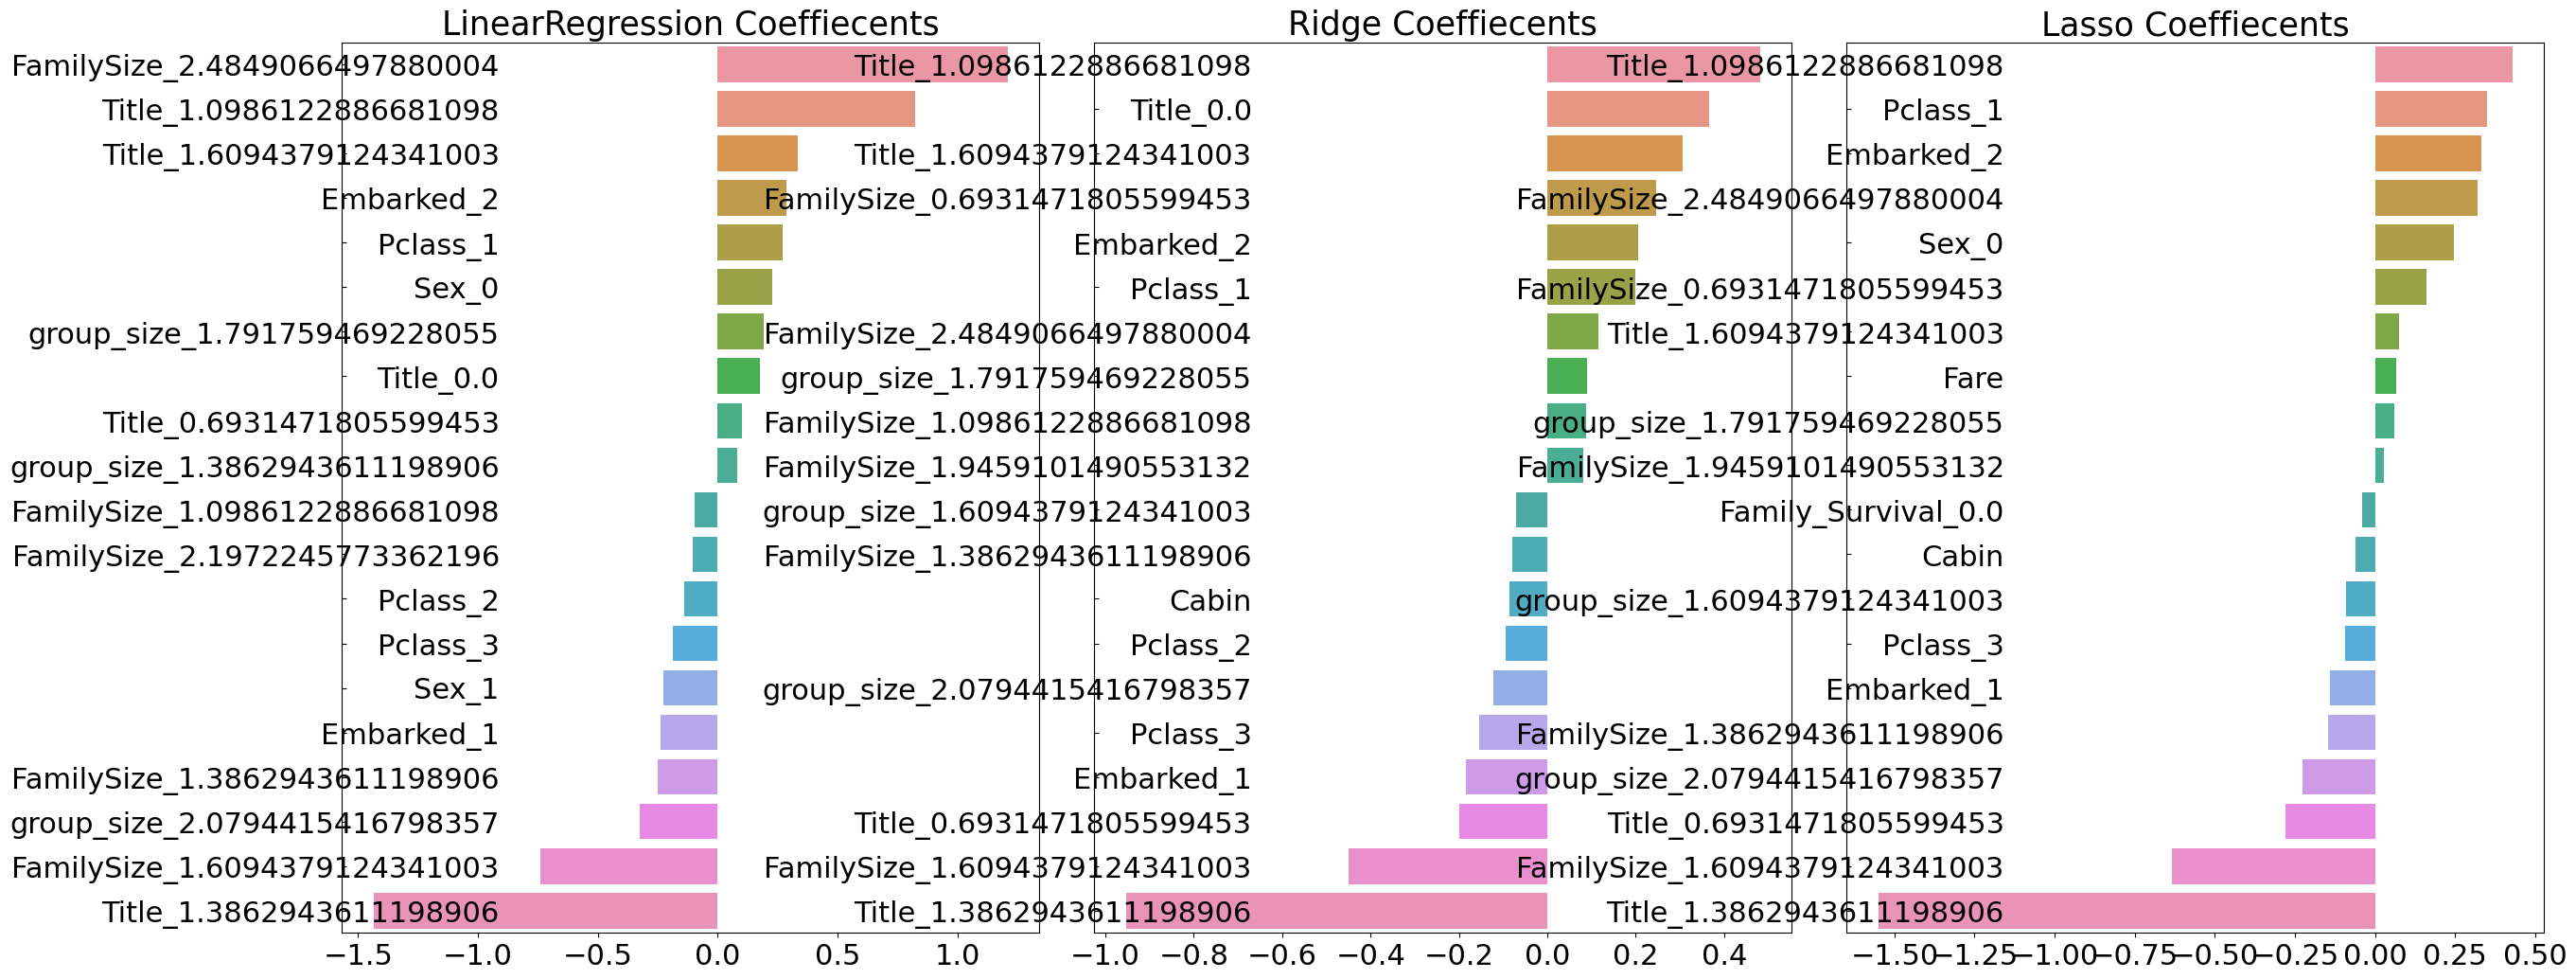

In [279]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)


# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [280]:
X_train.shape

(836, 35)

In [281]:
c=['absolute_error','friedman_mse','poisson','squared_error']
for r in range(1):
    rf_reg = RandomForestRegressor(random_state=135
                                , n_estimators=55
                                , max_depth=5
                                , min_samples_leaf=14
                                , criterion= 'absolute_error'
                                )                               
    rf_reg.fit(X_train,y_train)

    rf_pred = rf_reg.predict(X_test)
    r2score = r2_score(y_test,rf_pred)
    print(r,r2score)


0 0.6301271167872053


In [282]:
def get_model_cv_prediction(model, X_data, y_target):
    rmse_list=[]
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    # avg_rmse = np.mean(rmse_scores)
    rmse_list.append(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    # print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))
    print(rmse_list)

In [283]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
# for model in models:  
#     get_model_cv_prediction(model, X_train, y_train)


In [284]:
for r in range(1):
    xgb_reg = XGBRegressor(random_state=1
                        , n_estimators=140
                        , max_depth=2
                        ,learning_rate= 0.087 #(r / 1000)
                        )                               
    xgb_reg.fit(X_train,y_train)

    xgb_pred = xgb_reg.predict(X_test)
    r2score = r2_score(y_test,xgb_pred)
    print(r,r2score)

0 0.602622747482668


In [285]:
notnull_age.shape, isnull_age.shape

((1046, 11), (263, 11))

In [286]:
test_data = isnull_age.drop('Age',axis=1)

train_data = notnull_age.drop('Age',axis=1)
target = notnull_age['Age']

train_data.shape,target.shape

((1046, 10), (1046,))

In [287]:
rf_reg = RandomForestRegressor(random_state=135
                            , n_estimators=55
                            , max_depth=5
                            , min_samples_leaf=14
                            , criterion= 'absolute_error'
                            )                               
rf_reg.fit(train_data,target)

rf_pred = rf_reg.predict(test_data)


In [288]:
rf_pred.shape

(263,)

In [289]:
isnull_age['Age'] = rf_pred

In [290]:
isnull_age.isnull().sum()

PassengerId        0
Pclass             0
Sex                0
Age                0
Fare               0
Cabin              0
Embarked           0
Title              0
group_size         0
FamilySize         0
Family_Survival    0
dtype: int64

In [291]:
all_traintest = pd.concat([notnull_age,isnull_age],ignore_index=True)
all_traintest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      1309 non-null   int64  
 1   Pclass           1309 non-null   int64  
 2   Sex              1309 non-null   int64  
 3   Age              1309 non-null   float64
 4   Fare             1309 non-null   float64
 5   Cabin            1309 non-null   float64
 6   Embarked         1309 non-null   int64  
 7   Title            1309 non-null   int64  
 8   group_size       1309 non-null   float64
 9   FamilySize       1309 non-null   int64  
 10  Family_Survival  1309 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 112.6 KB


In [292]:
all_traintest = all_traintest.sort_values(by='PassengerId',ignore_index=True)

In [293]:
all_traintest['PassengerId']

0          1
1          2
2          3
3          4
4          5
        ... 
1304    1305
1305    1306
1306    1307
1307    1308
1308    1309
Name: PassengerId, Length: 1309, dtype: int64

In [294]:
all_traintest.loc[all_traintest['PassengerId']>=892, 'Age']

891     3.569533
892     3.871201
893     4.143135
894     3.332205
895     3.135494
          ...   
1304    3.285896
1305    3.688879
1306    3.676301
1307    3.285896
1308    2.529790
Name: Age, Length: 418, dtype: float64

In [295]:
test.loc[:,'Age']

0      34.5
1      47.0
2      62.0
3      27.0
4      22.0
       ... 
413     NaN
414    39.0
415    38.5
416     NaN
417     NaN
Name: Age, Length: 418, dtype: float64

In [296]:
test.loc[:,'Age'] = np.where(test['Age'].isnull(), all_traintest[all_traintest['PassengerId']>=892]['Age'], test['Age'])

In [297]:
train.loc[:,'Age'] = np.where(train['Age'].isnull(), all_traintest[all_traintest['PassengerId']<892]['Age'], train['Age'])

In [298]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      418 non-null    int64  
 1   Pclass           418 non-null    int64  
 2   Sex              418 non-null    int64  
 3   Age              418 non-null    float64
 4   Fare             418 non-null    float64
 5   Cabin            418 non-null    float64
 6   Embarked         418 non-null    int64  
 7   Title            418 non-null    int64  
 8   group_size       418 non-null    float64
 9   FamilySize       418 non-null    int64  
 10  Family_Survival  418 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 36.0 KB


---

In [299]:
# train,test = data_cleaning()

In [300]:
train['group_size'].unique()

array([1., 2., 4., 3., 7., 5., 6.])

In [301]:
train_test_data = [train,test]
for dataset in train_test_data:
    dataset.loc[dataset['Age'] <= 17, 'Age'] = 0
    dataset.loc[(dataset['Age'] >17) & (dataset['Age'] <= 24), 'Age'] = 1
    dataset.loc[(dataset['Age'] >24) & (dataset['Age'] <= 34), 'Age'] = 2
    dataset.loc[(dataset['Age'] >34) & (dataset['Age'] <= 44), 'Age'] = 3
    dataset.loc[(dataset['Age'] >44) & (dataset['Age'] <= 60), 'Age'] = 4
    dataset.loc[dataset['Age'] >60, 'Age'] = 5

train_test_data = [train,test]
for dataset in train_test_data:
    dataset.loc[dataset['group_size'] == 1, 'group_size'] = 0
    dataset.loc[dataset['group_size'] == 2, 'group_size'] = 0.4
    dataset.loc[(dataset['group_size'] == 3) | (dataset['group_size'] == 4), 'group_size'] = 0.8
    dataset.loc[dataset['group_size'] > 4, 'group_size'] = 1.2

train_test_data = [train,test]
for dataset in train_test_data:

    dataset.loc[dataset['Fare'] <= 7,'Fare'] = 0
    dataset.loc[(dataset['Fare'] >7) & (dataset['Fare'] <=8.8), 'Fare'] = 0.4
    dataset.loc[(dataset['Fare'] >8.8) & (dataset['Fare'] <=17), 'Fare'] = 0.8
    dataset.loc[(dataset['Fare'] >17) & (dataset['Fare'] <=30), 'Fare'] = 1.2
    dataset.loc[(dataset['Fare'] >30) & (dataset['Fare'] <=100), 'Fare'] = 1.6
    dataset.loc[dataset['Fare'] > 100,'Fare'] = 2

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
train['FamilySize'] = train['FamilySize'].map(family_mapping)
test['FamilySize'] = test['FamilySize'].map(family_mapping)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16864\3253093836.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['FamilySize'] = train['FamilySize'].map(family_mapping)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16864\3253093836.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['FamilySize'] = test['FamilySize'].map(family_mapping)


In [302]:
train['Cabin'].unique()

array([2. , 0.8, 1.6, 1.8, 2.4, 1.2, 0. , 0.4, 2.8])

In [303]:
# train = pd.get_dummies(train,columns=['Pclass','Sex','Title'])
# test = pd.get_dummies(test,columns=['Pclass','Sex','Title'])

In [304]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin',
       'Embarked', 'Title', 'group_size', 'FamilySize', 'Family_Survival'],
      dtype='object')

In [305]:
train,test = data_scaler(train,test,columns=['Pclass', 'Sex', 'Age', 'Fare', 'Cabin',
                                            'Embarked', 'Title', 'group_size', 'FamilySize', 'Family_Survival'])

In [306]:
train = train[['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin',
       'Embarked', 'Title', 'group_size','FamilySize', 'Family_Survival']]
test = test[['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked',
       'Title', 'group_size', 'FamilySize','Family_Survival']]

---

## modeling

In [307]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,group_size,FamilySize,Family_Survival
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,0.654321,0.352413,0.316723,0.365657,0.596280,0.180696,0.185185,0.205387,0.090460,0.519641
std,257.353842,0.486592,0.418036,0.477990,0.289169,0.246388,0.192977,0.317837,0.263019,0.299548,0.161346,0.323961
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,0.500000,0.000000,0.000000,0.200000,0.571429,0.000000,0.000000,0.000000,0.000000,0.500000
50%,446.000000,0.000000,1.000000,0.000000,0.200000,0.400000,0.714286,0.000000,0.000000,0.000000,0.000000,0.500000
75%,668.500000,1.000000,1.000000,1.000000,0.600000,0.600000,0.714286,0.500000,0.250000,0.333333,0.100000,0.500000
max,891.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [308]:
submission_a = load_submission_a()

In [309]:
train_data, target = split_data(train)

In [310]:
train_data.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,group_size,FamilySize,Family_Survival
0,1,1.0,0,0.2,0.2,0.714286,0.0,0.00,0.000000,0.1,0.5
1,2,0.0,1,0.6,0.8,0.285714,0.5,0.50,0.000000,0.1,0.5
2,3,1.0,1,0.4,0.2,0.714286,0.0,0.25,0.000000,0.0,0.5
3,4,0.0,1,0.6,0.6,0.285714,0.0,0.50,0.333333,0.1,0.0
4,5,1.0,0,0.6,0.2,0.714286,0.0,0.00,0.000000,0.0,0.5


In [162]:
# train_data, target, test = data_cleaning()

In [311]:
# 8373
clf = RandomForestClassifier(
                            max_depth=5
                              ,n_estimators=57
                             ,min_samples_leaf=45
                             , random_state=228
                             ,n_jobs=-1
                             )
clf.fit(train_data, target)

prediction = clf.predict(test)

accuracy = accuracy_score(prediction, submission_a)

accuracy

0.8110047846889952

In [164]:
submission = pd.DataFrame({

    'PassengerId':test['PassengerId']
    ,'Survived':prediction
    
})
submission.to_csv('submission.csv',index=False)

(143, 0.8253588516746412)